In [ ]:
pip install crc

**Parte 2: Implementação Manual do Algoritmo CRC**

In [21]:
import time
import tracemalloc
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
from crc import Calculator, Crc16

In [11]:
def xor_bits(a, b):
    return ''.join(['0' if x == y else '1' for x, y in zip(a, b)])


def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    mensagem_estendida = dados_bits + '0' * (len(gerador_bits) - 1)
    bits_usados = len(gerador_bits)

    temp = mensagem_estendida[0:len(gerador_bits)]

    while bits_usados < len(mensagem_estendida):
        if temp[0] == '0':
            temp = temp[1:] + mensagem_estendida[bits_usados]
        else:
            temp = xor_bits(temp, gerador_bits)[1:] + mensagem_estendida[bits_usados]
        bits_usados += 1

    if temp[0] == '1':
        temp = xor_bits(temp, gerador_bits)[1:]
    else:
        temp = temp[1:]

    return temp

In [12]:
# Exemplo de uso para validação
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"    # G(x)
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado: {crc_calculado}")
# Quadro T(x) a ser transmitido: dados_teste + crc_calculado

Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 0010


**Parte 3: Análise Comparativa de Desempenho**

In [13]:
# Usando um padrão de 16 bits como referência
calculator_lib = Calculator(Crc16.MODBUS)

# Tamanhos de mensagem para teste (em bytes)
tamanhos_bytes = [1500, 3000 , 6000 , 16000]

resultados = []

for tamanho in tamanhos_bytes:
    print(f"Analisando para mensagem de {tamanho} bytes...")
    # Gere uma mensagem aleatória de bits
    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)

    # Medição da nossa Implementação
    tracemalloc.start()
    start_time = time.perf_counter()

    crc_manual = calcular_crc_manual(mensagem_bits, "11000000000000101") # G(x) do CRC-16/MODBUS

    end_time = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_manual = end_time - start_time

    # Medição da Biblioteca
    tracemalloc.start()
    start_time = time.perf_counter()

    crc_lib = calculator_lib.checksum(mensagem_bytes)

    end_time = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_lib = end_time - start_time

    # Armazene os resultados
    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024, # em KiB
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024 # em KiB
    })

print("--- Resultados Finais ---")
print(resultados)

Analisando para mensagem de 1500 bytes...
Analisando para mensagem de 3000 bytes...
Analisando para mensagem de 6000 bytes...
Analisando para mensagem de 16000 bytes...
--- Resultados Finais ---
[{'tamanho': 1500, 'tempo_manual': 0.045337356999880285, 'mem_pico_manual': 18.962890625, 'tempo_lib': 0.048610071999974025, 'mem_pico_lib': 0.796875}, {'tamanho': 3000, 'tempo_manual': 0.049674897999921086, 'mem_pico_manual': 24.0771484375, 'tempo_lib': 0.09964183800002502, 'mem_pico_lib': 4.412109375}, {'tamanho': 6000, 'tempo_manual': 0.10150478400009888, 'mem_pico_manual': 50.9814453125, 'tempo_lib': 0.19850548600015827, 'mem_pico_lib': 0.98046875}, {'tamanho': 16000, 'tempo_manual': 0.2726996700002928, 'mem_pico_manual': 129.0771484375, 'tempo_lib': 0.5379181570001492, 'mem_pico_lib': 0.69140625}]


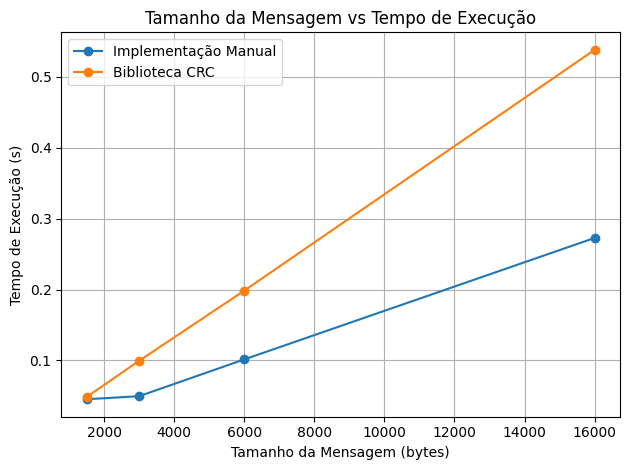

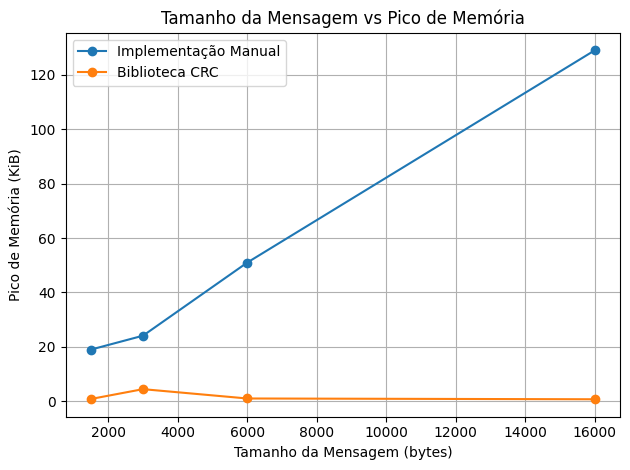

In [14]:
tamanhos = [r["tamanho"] for r in resultados]
tempos_manual = [r["tempo_manual"] for r in resultados]
tempos_lib = [r["tempo_lib"] for r in resultados]
mem_manual = [r["mem_pico_manual"] for r in resultados]
mem_lib = [r["mem_pico_lib"] for r in resultados]

# --- Gráfico 1: Tamanho da Mensagem vs Tempo de Execução ---
plt.figure()
plt.plot(tamanhos, tempos_manual, marker='o', label='Implementação Manual')
plt.plot(tamanhos, tempos_lib,    marker='o', label='Biblioteca CRC')
plt.xlabel('Tamanho da Mensagem (bytes)')
plt.ylabel('Tempo de Execução (s)')
plt.title('Tamanho da Mensagem vs Tempo de Execução')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Gráfico 2: Tamanho da Mensagem vs Pico de Memória ---
plt.figure()
plt.plot(tamanhos, mem_manual, marker='o', label='Implementação Manual')
plt.plot(tamanhos, mem_lib,    marker='o', label='Biblioteca CRC')
plt.xlabel('Tamanho da Mensagem (bytes)')
plt.ylabel('Pico de Memória (KiB)')
plt.title('Tamanho da Mensagem vs Pico de Memória')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Especificações da máquina que executou o código:**

**Sistema Operacional**: Linux Ubuntu 22.04

**Processador (CPU)**: AMD Ryzen 7 5700x

**Memória RAM**: 16 GB

**GPU**: AMD RX7600

**Disco**: SSD Nvme 256GB

**Ambiente de execução**: VSCode

**Parte 4: Análise Investigativa da Detecção de Erros**

In [18]:
#Parte 4.1

mensagem_base = "010101100110100101101110111011010110001101101001011101010111001100100000010010010110000101101110001000000100000101101100011101100110010101110011001000000100110001101111011100000110010101110011"
gerador_pessoal = "11000000000000101"

crc_pessoal = calcular_crc_manual(mensagem_base, gerador_pessoal)

print(f"Dados M(x): {mensagem_base}")
print(f"Gerador G(x): {gerador_pessoal}")
print(f"CRC Calculado: {crc_pessoal}")

Dados M(x): 010101100110100101101110111011010110001101101001011101010111001100100000010010010110000101101110001000000100000101101100011101100110010101110011001000000100110001101111011100000110010101110011
Gerador G(x): 11000000000000101
CRC Calculado: 1011111010100101


In [ ]:
#Parte 4.2

quadro_transmitido = mensagem_base + crc_pessoal

print(f"Quadro Transmitido T(x): {quadro_transmitido}")

def gerar_erro_rajada(quadro: str, n_bits: int):
    pos = random.randint(0, len(quadro) - n_bits)

    erro_bin_original = quadro[pos:pos + n_bits]

    quadro_corrompido = list(quadro)
    for i in range(n_bits):
        idx = pos + i
        quadro_corrompido[idx] = '1' if quadro[idx] == '0' else '0'

    quadro_corrompido_str = ''.join(quadro_corrompido)
    
    return pos, n_bits, erro_bin_original, quadro_corrompido_str

def bits_para_bytes(bits: str) -> bytes:
    bits = bits.zfill((len(bits) + 7) // 8 * 8)
    return int(bits, 2).to_bytes(len(bits) // 8, byteorder='big')

# Executa os testes
resultados_erros = []

for _ in range(10):
    n_bits_erro = random.randint(1, 16)
    pos, n_bits, erro_bin, quadro_corrompido = gerar_erro_rajada(quadro_transmitido, n_bits_erro)

    crc_manual_result = calcular_crc_manual(quadro_corrompido, gerador_pessoal)

    quadro_corrompido_bytes = bits_para_bytes(quadro_corrompido)
    crc_lib_result = calculator_lib.checksum(quadro_corrompido_bytes)

    resultados_erros.append({
        "posição_erro": pos,
        "bits_invertidos": n_bits,
        "erro_bin": erro_bin,
        "erro_detectado_manual": set(crc_manual_result) != {'0'},
        "erro_detectado_lib": crc_lib_result != 0
    })


df_resultados = pd.DataFrame(resultados_erros)
print(df_resultados.to_string(index=False))


Quadro Transmitido T(x): 0101011001101001011011101110110101100011011010010111010101110011001000000100100101100001011011100010000001000001011011000111011001100101011100110010000001001100011011110111000001100101011100111011111010100101
 posição_erro  bits_invertidos        erro_bin  erro_detectado_manual  erro_detectado_lib
           27               11     01101011000                   True                True
          152                9       010011000                   True                True
          112                8        01101100                   True                True
           80                3             011                   True                True
           38                4            1101                   True                True
          172               15 000001100101011                   True                True
            7               15 001101001011011                   True                True
           26               11     10110101100

**Pela robustez da mensagem não foi possível encontar um caso em que o erro fosse despercebido**

## 🧪 Relatório de Testes: Detecção de Erros com CRC-16/MODBUS

### 🔹 Quadro Transmitido `T(x)`
0101011001101001011011101110110101100011011010010111010101110011001000000100100101100001011011100010000001000001011011000111011001100101011100110010000001001100011011110111000001100101011100111011111010100101


---

### 🔹 Resultados dos 10 Testes com Erros de Rajada

| Teste | Posição do Erro | Bits Invertidos | Padrão de Erro (`erro_bin`) | Detectado (Manual) | Detectado (Biblioteca) |
|-------|------------------|------------------|-------------------------------|---------------------|-------------------------|
| 1     | 27               | 11               | 01101011000                  | ✅ Sim              | ✅ Sim                  |
| 2     | 152              | 9                | 010011000                    | ✅ Sim              | ✅ Sim                  |
| 3     | 112              | 8                | 01101100                     | ✅ Sim              | ✅ Sim                  |
| 4     | 80               | 3                | 011                          | ✅ Sim              | ✅ Sim                  |
| 5     | 38               | 4                | 1101                         | ✅ Sim              | ✅ Sim                  |
| 6     | 172              | 15               | 000001100101011              | ✅ Sim              | ✅ Sim                  |
| 7     | 7                | 15               | 001101001011011              | ✅ Sim              | ✅ Sim                  |
| 8     | 26               | 11               | 10110101100                  | ✅ Sim              | ✅ Sim                  |
| 9     | 30               | 12               | 010110001101                 | ✅ Sim              | ✅ Sim                  |
| 10    | 101              | 15               | 000010000010110              | ✅ Sim              | ✅ Sim                  |

---

### 🔎 Comparação entre Implementações

- **Implementação Manual**: Detectou corretamente todos os erros.
- **Biblioteca CRC (`crc`)**: Também detectou todos os erros.
- **Diferença**: Nenhuma. Ambas funcionaram de forma idêntica nos testes realizados.

Ambas as implementações (manual e biblioteca) detectaram corretamente todos os erros simulados.
Nenhum caso de falha foi encontrado.
Isso demonstra que a implementação manual está em conformidade com o padrão CRC-16/MODBUS e que
o algoritmo é robusto para detectar rajadas de erro pequenas e médias.
Porém, sabe-se que erros construídos de forma específica (múltiplos do polinômio) podem não ser
detectados, o que não foi observado nos testes práticos realizados.

---

### ⚠️ Reflexão sobre as Limitações do CRC

Apesar do desempenho perfeito nos testes:
- O CRC **não é infalível**: ele pode falhar se o erro introduzido for um múltiplo do polinômio gerador.
- Todos os erros de **até 16 bits contínuos** foram detectados com sucesso.
- **Nenhum erro passou despercebido** por nenhuma das implementações neste conjunto de testes.

**Conclusão**:  
O CRC-16/MODBUS demonstrou excelente confiabilidade. Nenhum erro passou despercebido por nenhuma
das implementações, mesmo com erros de rajada em diferentes tamanhos e posições.
As implementações se mostraram funcionalmente equivalentes, reforçando a robustez do CRC em cenários
de comunicação realista.


**Link para o repositório com o notebook e o readme da atividade:** https://github.com/ViniciusI4n/redes-atvd2
